# [Computational Social Science]
## 5-3 Text Feature Engineering and Classification - Solutions

In this lab we will use the techniques we covered so far to engineer text features and train a classification algorithm.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [1]:
# load libraries
# ----------
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# settings
%matplotlib inline

## Data

<img src = "../../images/cfpb logo.png"  />

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). Picking up from where we left off last time, we'll focus on predicting whether a consumer complaint narrative is talking about a "checkings or savings account" issue or a "student loan" issue.

In [2]:
# load the data
# ----------
# load data
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")

# drop missing on "Consumer complaint narrative" feature and reset the index bc we've dropped
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])

# filtering to keep only savings and student loan products
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]

# filtering to keep the first 1000 rows
cfpb = cfpb[:1000]

## Text Preprocessing

Before we do any feature engineering or classification, we should first preprocess our text. Let's start by adding custom stop words and defining our custom `rem_punc_stop()` function:

In [3]:
# add a few words analysis-specific words to our Stop Words
# ----------
STOP_WORDS = STOP_WORDS.union({"XX", "XXXX","XXXXXXXX"})

# what are some ways we might check to see if these stop words were added
# ----------
# option 1: visually check these were added
print(STOP_WORDS)

# option 2: count the length: should be 329
print(len(STOP_WORDS))

{'via', "n't", 'after', 'such', 'no', 'twenty', 'there', 'back', 'neither', 'because', 'those', 'hers', 'just', 'upon', 're', 'nobody', 'had', 'even', 'somehow', 'its', 'nine', 'since', 'unless', 'all', 'they', 'their', 'enough', 'at', 'among', 'serious', 'much', 'whither', 'ever', 'us', 'against', 'where', 'become', 'i', 'can', 'more', 'yours', 'as', 'from', 'beside', 'throughout', 'though', 'our', 'really', 'while', 'am', 'however', 'me', 'something', 'it', 'whatever', 'been', 'toward', 'someone', 'you', 'not', 'yourselves', 'your', 'see', 'either', 'ca', 'third', 'yourself', 'amongst', 'about', 'when', 'up', 'moreover', 'once', 'nowhere', 'seems', 'are', 'using', 'often', 'wherein', 'thus', 'we', 'over', 'full', 'hereby', 'top', 'out', 'for', 'anywhere', 'formerly', 'seemed', 'whoever', 'which', 'every', 'onto', 'my', 'take', 'therein', 'would', 'between', "'s", 'besides', 'might', 'too', "'ll", 'forty', 'others', 'herself', 'whenever', 'another', 'sometime', 'side', 'make', 'twelve

**CHALLENGE:** Label what each line is doing. 

In [4]:
# create preprocessing function - like we have in the past few labs
# ----------
def rem_punc_stop(text):
    
    # set objects
    punc = set(punctuation)
    
    # remove punctuation by iterating over each character and only joining characters not in the "punctuation" set 
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out stop words
    no_punc = [word for word in spacy_words if word not in STOP_WORDS]
    
    # return
    return no_punc

Now let's go ahead and apply our function to the consumer complaint narratives. Notice how the `rem_punc_stop()` function returns a list, but we can collapse our tokens back into strings with the `join()` string method.

Note that this will take a few moments to run, so be patient. 


**CHALLENGE:** In the Student version, there is no space in the third line, so when the text is collapsed, there are no spaces between each word. You can fix it by changeing '' to ' ' as is done here. 

In [5]:
# apply our preprocessing function to the consumer complaint column in our original dataframe
# ----------

# remove punctuation and stop words
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))

# collapse tokens in a string using join method since output of last step is a list
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))

# view
cfpb['tokens']

99       I lost card lunch run break lunch realized nt ...
234      In response answer dated You stated USAA utili...
332      On XXXX2020 wife I opened business account Nav...
346      I signed opened citibank checking account late...
397      On XXXX2020 CARES Act signed federal law indic...
                               ...                        
42908    My student loans serviced Navient Circa 2012 N...
43000    On 2019 I debit card purchase denied After inv...
43048    On I received fraud check fake company contact...
43049    I m filing complaint AscendiumXXXX   Departmen...
43054    I believe I taken advantage Wells Fargo Bank c...
Name: tokens, Length: 1000, dtype: object

## Wrap up EDA

We've already explored several exploratory data analysis techniques. There are many different ways to explore text data that we haven't covered, but let's take a look at one last basic tool: visualizing n-grams.  

In [6]:
# initialize the Bag-of-Words CounterVectorizer
# ----------
# notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(2,3))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix - need to densify bc DataFrame can't handle sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # specify data to convert to dataframe 
                                    columns = countvec.get_feature_names_out()) # get features

/Users/Dora/anaconda3/envs/CSS2/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


In [7]:
# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view the first few lines
df_ngram.head()

,ngrams,freq
0,wells fargo,337
1,checking account,303
2,debit card,208
3,bank america,198
4,customer service,171


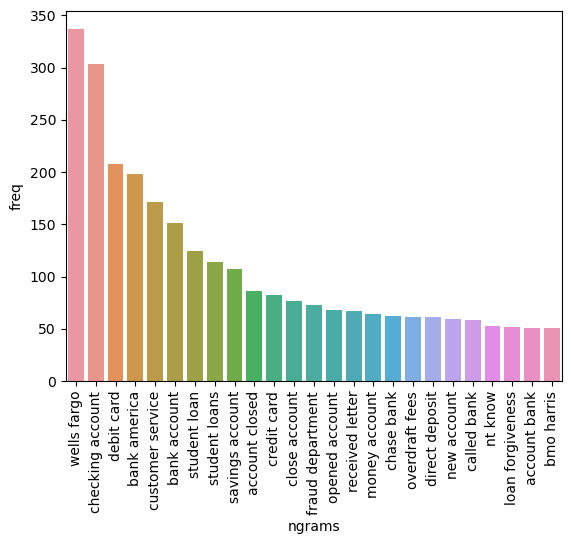

In [8]:
# create bar plot visualization
# ----------
sns.barplot(x="ngrams", 
            y = 'freq', 
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**CHALLENGE:** Adjust the code above to visualize the most popular unigrams and 4-grams. What is the tradeoff involved with increasing n?

/Users/Dora/anaconda3/envs/CSS2/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


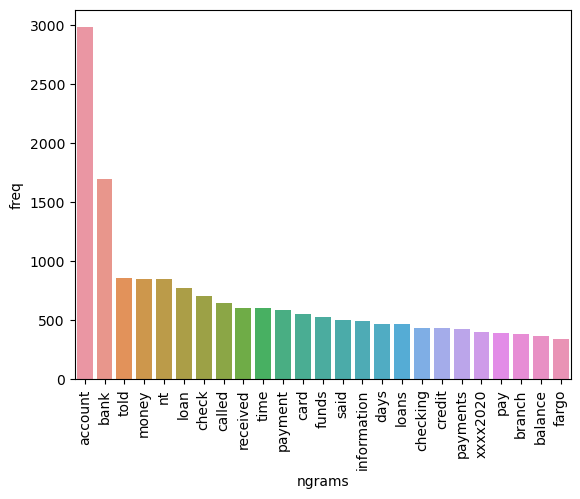

In [9]:
# adjust to count unigrams and 4-grams
# ----------
countvec = CountVectorizer(stop_words=list(STOP_WORDS), 
                           ngram_range=(1,1))
ngrams = countvec.fit_transform(cfpb['tokens'])

# create dataframe of n-grams and their frequency 
dictionary_dataframe = pd.DataFrame(ngrams.todense(), 
                                    columns = countvec.get_feature_names_out())

# create dataframe of n-grams and their frequency 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

# create bar plot visualization
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

/Users/Dora/anaconda3/envs/CSS2/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


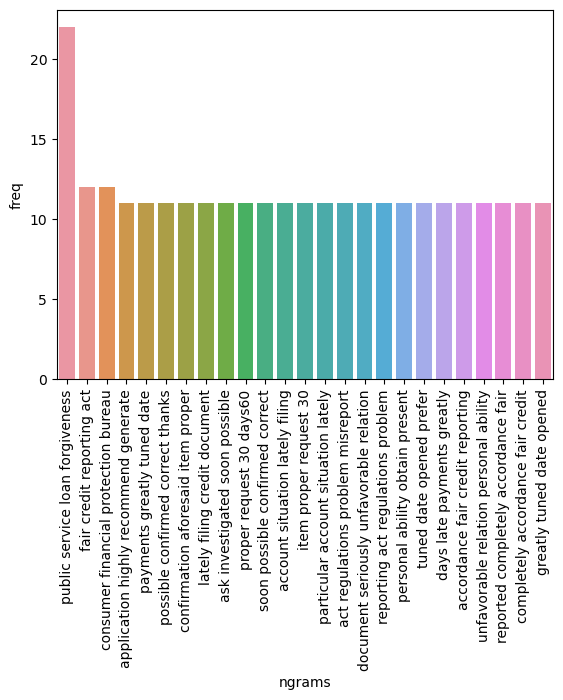

In [10]:
# adjust to count unigrams and 4-grams
# ----------

countvec = CountVectorizer(stop_words=list(STOP_WORDS), ngram_range=(4,4))
ngrams = countvec.fit_transform(cfpb['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**ANSWER**: Increasing `n` does pick up much more unique phrases (like "public service loan forgiveness"), but the overall frequencies are quite low and potentially unhelpful. At the extreme, you could imagine making an n-gram that was as long as an entire document - it would perfectly classify that document but nothing else. This is similar to the bias-variance tradeoff and the dangers with overfitting.

## Feature Engineering

Last time, we saw some techniques for exploring the text of our data. Specifically, we saw how to find the length of our text and word counts:

In [11]:
# find the character count for each document 
# --------
# apply length function to tokens column to count each character
cfpb['complaint_len'] = cfpb['tokens'].apply(len)

# view the new feature we just created
cfpb[['tokens', 'complaint_len']]

,tokens,complaint_len
99,I lost card lunch run break lunch realized nt ...,358
234,In response answer dated You stated USAA utili...,488
332,On XXXX2020 wife I opened business account Nav...,234
346,I signed opened citibank checking account late...,196
397,On XXXX2020 CARES Act signed federal law indic...,1155
...,...,...
42908,My student loans serviced Navient Circa 2012 N...,567
43000,On 2019 I debit card purchase denied After inv...,690
43048,On I received fraud check fake company contact...,992
43049,I m filing complaint AscendiumXXXX Departmen...,1016


In [12]:
# find the word count for each document 
# --------
# apply length function to tokens column to count words -- you will need to split the text to count words
cfpb['word_count'] = cfpb['tokens'].apply(lambda x: len(str(x).split()))

# view
cfpb[['tokens', 'complaint_len', 'word_count']]

,tokens,complaint_len,word_count
99,I lost card lunch run break lunch realized nt ...,358,60
234,In response answer dated You stated USAA utili...,488,73
332,On XXXX2020 wife I opened business account Nav...,234,36
346,I signed opened citibank checking account late...,196,31
397,On XXXX2020 CARES Act signed federal law indic...,1155,145
...,...,...,...
42908,My student loans serviced Navient Circa 2012 N...,567,76
43000,On 2019 I debit card purchase denied After inv...,690,108
43048,On I received fraud check fake company contact...,992,165
43049,I m filing complaint AscendiumXXXX Departmen...,1016,152


We also covered subjectivity and sentiment:

In [13]:
# create polarity and subjectivity features
# --------
# notice that text is just a name for an element over which we will iterate
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)   # iterate over "text" element
cfpb['subjectivity'] = cfpb['tokens'].map(lambda x: TextBlob(x).sentiment.subjectivity) # iterate over "x" element

# view
cfpb[['tokens', 'complaint_len', 'word_count', 'polarity', 'subjectivity']]

,tokens,complaint_len,word_count,polarity,subjectivity
99,I lost card lunch run break lunch realized nt ...,358,60,-0.000481,0.573558
234,In response answer dated You stated USAA utili...,488,73,0.500000,0.500000
332,On XXXX2020 wife I opened business account Nav...,234,36,0.000000,0.000000
346,I signed opened citibank checking account late...,196,31,-0.166667,0.400000
397,On XXXX2020 CARES Act signed federal law indic...,1155,145,0.007424,0.363081
...,...,...,...,...,...
42908,My student loans serviced Navient Circa 2012 N...,567,76,0.033333,0.352778
43000,On 2019 I debit card purchase denied After inv...,690,108,0.000531,0.362249
43048,On I received fraud check fake company contact...,992,165,0.057311,0.630084
43049,I m filing complaint AscendiumXXXX Departmen...,1016,152,-0.150000,0.475000


### Build a Dictionary

Before we continue, let's take the top 25 n-grams we found earlier and turn them into their own dataframe. We'll return to these later.

In [14]:
# build a dictionary
# --------

# create a count of words after dropping stop words
countvec = CountVectorizer(stop_words=list(STOP_WORDS),  # use our list of stop words
                           ngram_range=(2,3))            # specify bi- and tri-grams

# apply countvec function to our tokenized data
ngrams = countvec.fit_transform(cfpb['tokens'])

# create dictionary - but note 
dictionary_dataframe = pd.DataFrame(ngrams.todense(), 
                                    columns = countvec.get_feature_names_out())


# create ngram frequency dataframe by summing over dictionary dataframe
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view just a subset
top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

/Users/Dora/anaconda3/envs/CSS2/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


,wells fargo,checking account,debit card,bank america,customer service,bank account,student loan,student loans,savings account,account closed,...,money account,chase bank,overdraft fees,direct deposit,new account,called bank,nt know,loan forgiveness,account bank,bmo harris
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Challenge: Topic Modeling

Using the code we went over from the last lab, make a dataframe with 5 LDA generated topics. Then, create a topic model using [Non-Negative Matrix Factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) and print out the words associated with the first 5 topics. NMF is another algorithm that is frequently used for topic modeling. 

**QUESTION:** Do you get similar topics as with your LDA topics? 

In [15]:
# first, let's define a function to print the top words that we'll use in our model
# --------

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [16]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = cfpb['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5, # specify the number of components
                                max_iter=20,    # specify the number of iterations 
                                random_state=0) # set a seed for reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df


Topic #0:
   account bank 

  loan money nt check told 
  card loans payment funds called received xxxx2020 time payments said

Topic #1:
hsbc delta 37000 acccounts wsfs waves compromised horizon ombudsmen venue disaster onaround pod firstbank pr firstbankpr plc cds garnishments multiple

Topic #2:
weekends aplied numbers expand brinks mastercard 4x continuous keybank hours cds structuring immoral prepaid od georgia cb synovus tryed beat

Topic #3:
ozk barrow 42000 bird blue pymt wrongdoings voted warnings alliant barrows reneging expects threatens traffic la withdrwl trailer cheats ample

Topic #4:
credit lately relation unfavorable prefer misreport days120 days60 tuned aforesaid recommend generate particular seriously highly accordance greatly item present regulations



,0,1,2,3,4
0,0.888044,0.027987,0.027987,0.027987,0.027996
1,0.887775,0.028029,0.028029,0.028029,0.028139
2,0.853491,0.036561,0.036561,0.036561,0.036825
3,0.864326,0.033908,0.033908,0.033908,0.033950
4,0.910056,0.022477,0.022478,0.022478,0.022511
...,...,...,...,...,...
995,0.894677,0.026330,0.026330,0.026330,0.026333
996,0.907977,0.023006,0.023006,0.023006,0.023005
997,0.914250,0.021436,0.021437,0.021437,0.021440
998,0.911938,0.022003,0.022004,0.022004,0.022051


In [17]:
#
# Non-Negative Matrix Factorization (NMF)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = cfpb['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
nmf = NMF(n_components=5,  # specify the number of components
          init='random',   # specify the initalization method
          random_state=1)  # set a seed for reproducibility

# fit NMF model to our dense matrix
nmf = nmf.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(nmf,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see


# now transform our data using the lda model and create a dataframe
nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
nmf_topic_dist_df


Topic #0:
fargo wells    claim complaint mediation card information 

  removed xxxx2019 reply charge cfpb 
  charges investigation resolution letter account

Topic #1:
credit prefer tuned days60 days120 misreport unfavorable aforesaid lately recommend relation generate particular seriously highly item accordance greatly present regulations

Topic #2:
account bank check    money nt told card funds xxxx2020 branch said 

  chase called america closed 
  fees fraud

Topic #3:
loan loans    navient payments payment student interest years 

  repayment program paid forgiveness school plan income fedloan pay education

Topic #4:
bonus    account citibank days citi checking opened offer requirements receive savings opening 

  new received 60 direct promotion 90



,0,1,2,3,4
0,0.000223,0.000000,0.044191,0.000000,0.000000
1,0.000286,0.004470,0.017774,0.004407,0.007684
2,0.000000,0.028994,0.023267,0.018119,0.000000
3,0.000000,0.010909,0.001936,0.000000,0.096908
4,0.002043,0.005907,0.000000,0.059054,0.007810
...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.092454,0.000000
996,0.002726,0.000000,0.052567,0.000000,0.000000
997,0.045772,0.000000,0.045717,0.000000,0.000000
998,0.004943,0.008080,0.009295,0.075524,0.011954


**ANSWER**: Somewhat - Topic #4 from LDA is similar to Topic #1 from NMF about Loan forgiveness for example.

## Classification

Now we're ready to move to classification! We are going to examine how different featurization techniques compare. Create a list with the following:
 * Text Engineered Features
 * Text Engineered Features + Topic Model
 * Non-Text Features only
 * Non-Text Features + Text Engineered Features
 * Tf-idf
 * Non-Text Features + tf-idf
 * Non-Text Features + Top 25 n-gram

You'll need to use pandas to create and .`join()` these different dataframes together. Also be sure to use `reset_index()` as necessary. Once you've created each of these dataframes (or arrays!) you should loop through all of them, train a supervised learning algorithm (like logistic regression or a decision tree classifier), and plot confusion matrices. Once you do this, think about which featurization technique worked the best, and whether combining text and non-text features was helpful. For now, don't worry about hyperparameter tuning or feature selection, though you would do these in practice.

In [18]:
# let's first take a look at the column names to get a sense of what we have
# --------
cfpb.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'tokens',
       'complaint_len', 'word_count', 'polarity', 'subjectivity'],
      dtype='object')

In [19]:
#
# pre-processing for a classification model
# ---------------------------------------


# Engineered Text Features
# --------
# select engineered text features
engineered_features = cfpb[['complaint_len', 
                            'word_count', 
                            'polarity', 
                            'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
# --------
# combine results from our topic model + engineered features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))


# Non-text features
# --------
# select non-text features
non_text_features = cfpb[['Company public response', 
                          'Company',
                          'State', 
                          'Consumer consent provided?',
                          'Submitted via', 
                          'Company response to consumer',
                          'Timely response?']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)



# Non-text features + engineered features
# --------
# combine non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)


# Non-text features + tfidf
# --------

# create dataframe of tf-idf 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # set feature names

# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)


# Non-Text Features + Top 25 n-gram
# --------
# combine non-text features and Top 25 ngrams (from above)
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)



In [20]:
# more pre-processing 
# --------

# create a list of dataframes from the objects created above
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
              top_25_ngrams,
              non_text_with_ngrams]


# create a list of labeles based on the objects created above
featurization_technique = ['Engineered Text Features',
                           'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                           'Top 25 N-Gram Features',
                           'Non-Text + Top 25 N-Gram Features']

# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = cfpb['Product_binary'] = lb_style.fit_transform(cfpb["Product"])


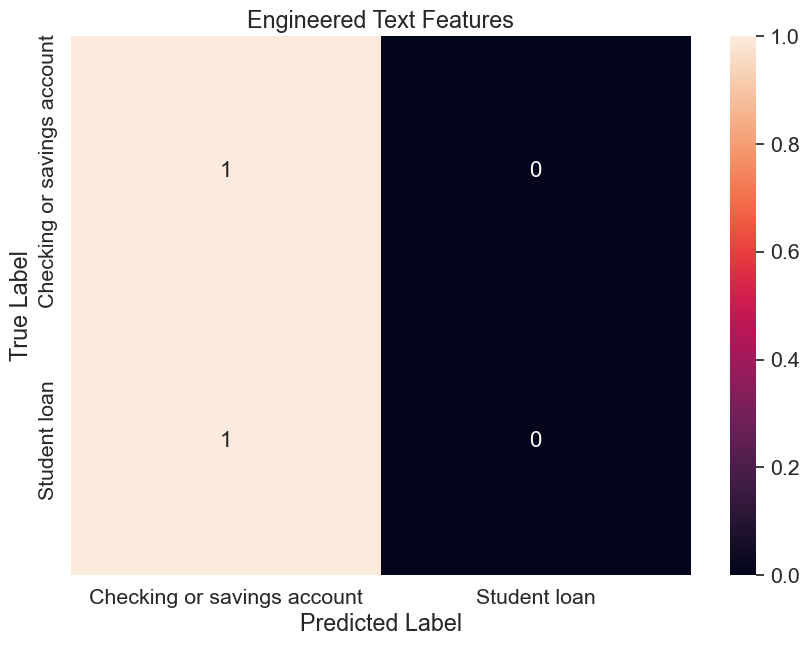

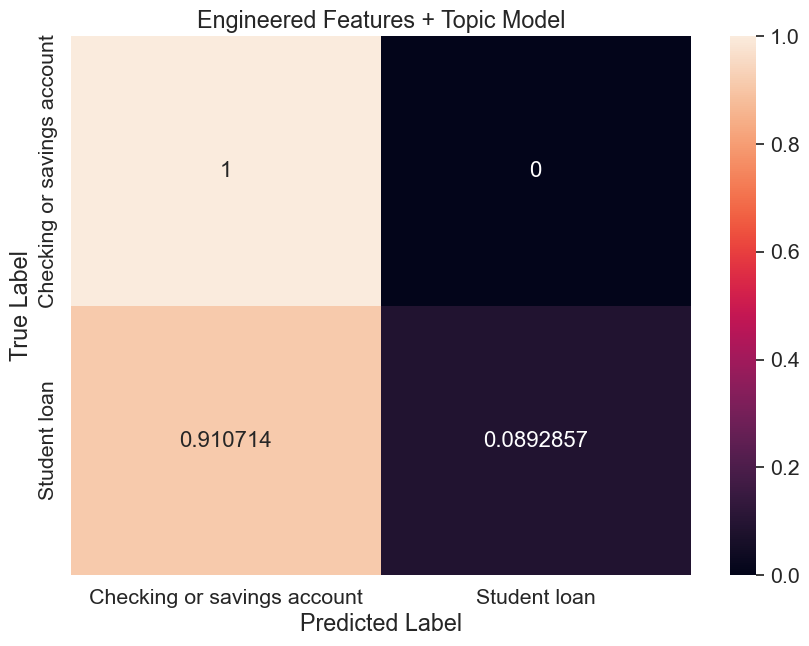

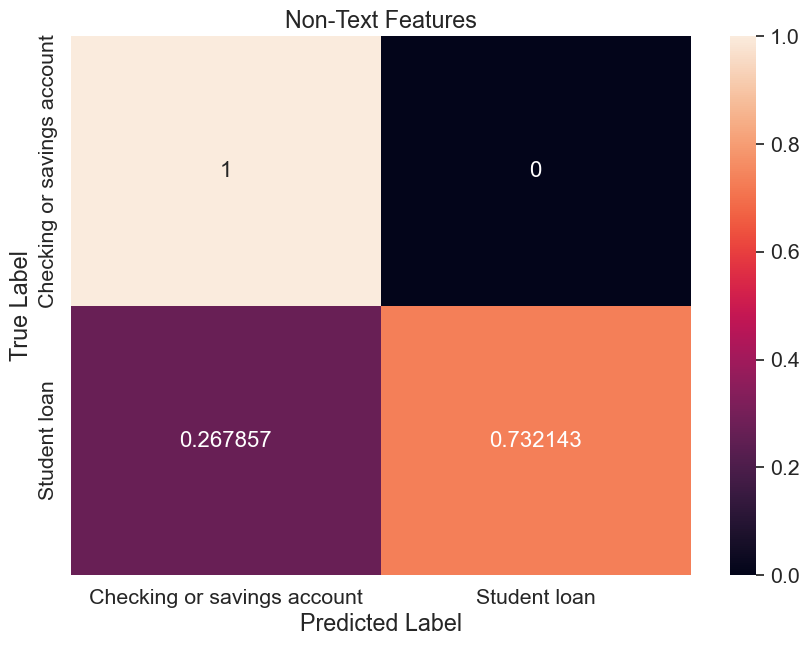

/Users/Dora/anaconda3/envs/CSS2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


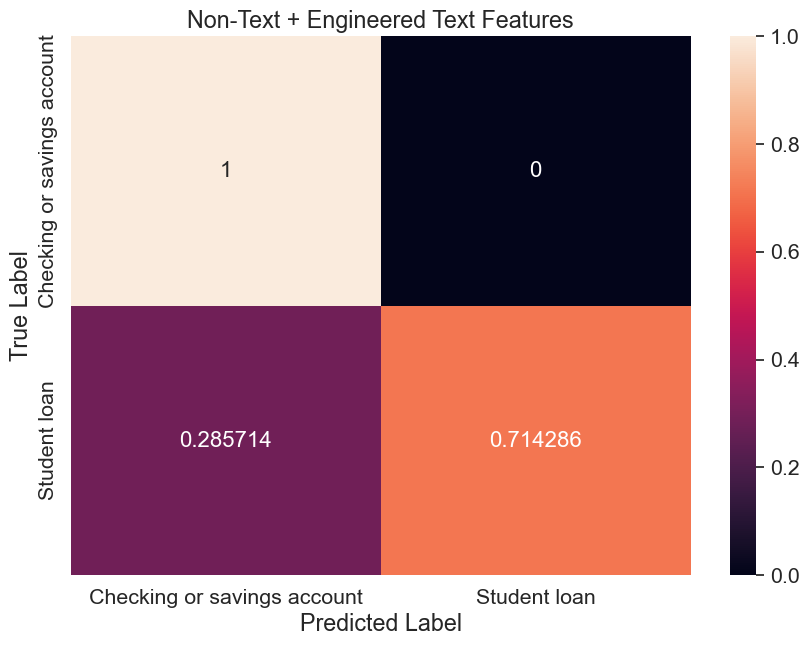

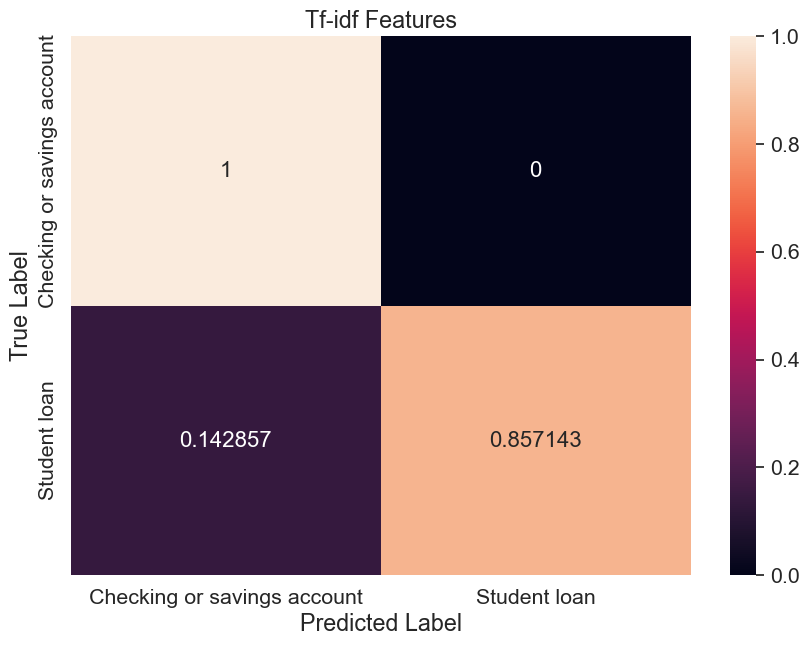

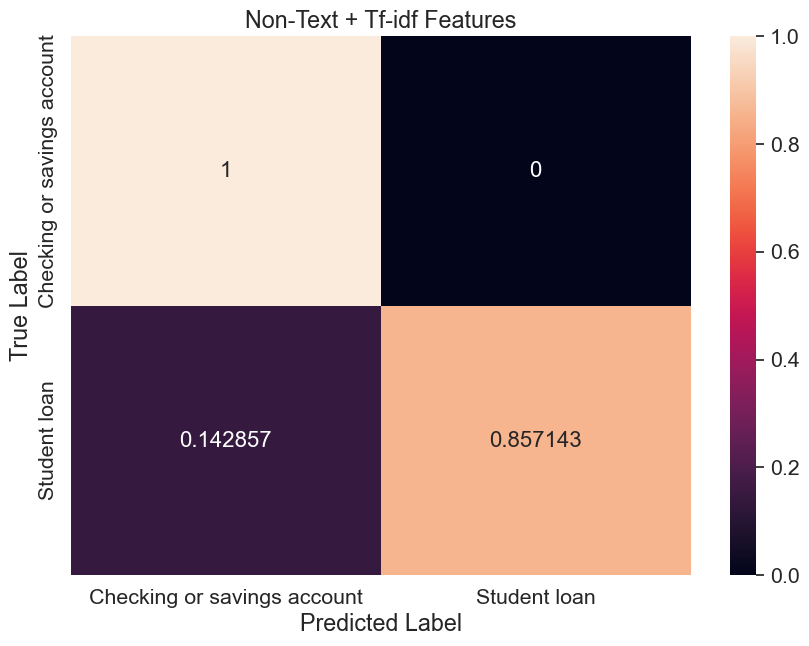

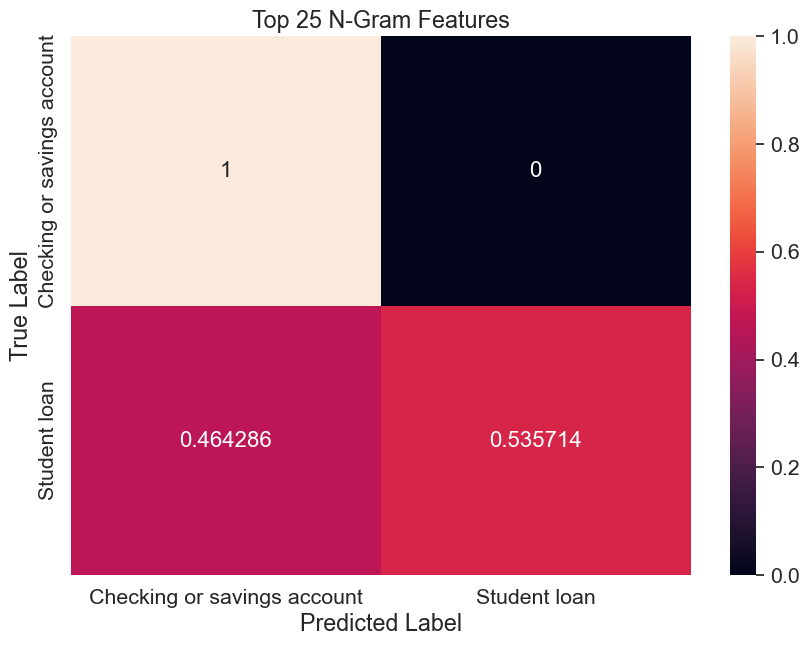

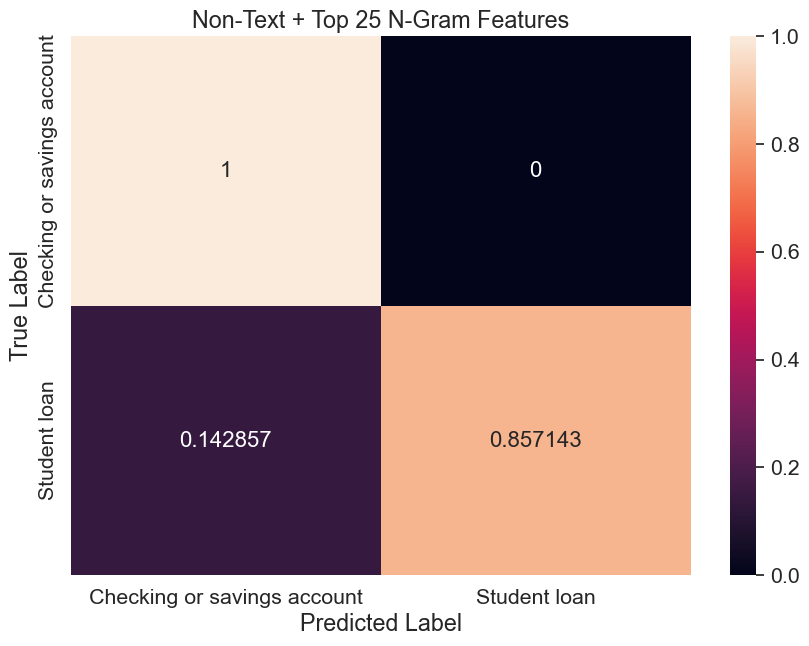

In [21]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression()

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Checking or savings account", 
                                  1: "Student loan"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Checking or savings account", "Student loan"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion

In general, combing text with non-text features will improve a classifier's performance. However this isn't automatic - in some cases you can actually degrade a classifier's performance by adding in more features.

In this case, our engineered features were too quick to predict "checking or savings account" and our tf-idf alone outperformed tf-idf + non-text features. 

However, non-text features + n-grams was tied with tf-idf alone! We might prefer the former approach because it is computationally cheaper, and likely easier to explain.

---
Notebook developed by Aniket Kesari. Modified by Prashant Sharma (2023) and annotated by Kasey Zapatka (2024).